In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
import natsort

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("tf version =",tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf version = 2.2.0-dev20200416


## Import data

In [2]:
tpath = "ESOL/ESOL.csv"

data0 = pd.read_csv(tpath)
data0["Compound ID"].replace({"Atovaquone(0,430mg/ml) - neutral": "Atovaquone"}, inplace=True)
data0["Compound ID"].replace({"Etoposide (148-167,25mg/ml)": "Etoposide"}, inplace=True)
data0["Compound ID"].replace({"Sparsomycin (3,8mg/ml)": "Sparsomycin"}, inplace=True)
data0["Compound ID"].replace({"Digoxin (L1=41,8mg/mL, L2=68,2mg/mL, Z=40,1mg/mL)": "Digoxin"}, inplace=True)

data0.head()

data = data0.iloc[np.random.permutation(len(data0))] #randomly shuffles rows

data.head()

Compound ID  ESOL predicted log solubility in mols per litre  \
198  2-Chlorotoluene                                           -3.297   
267    1-Bromobutane                                           -2.303   
479    Tetrafluthrin                                           -6.339   
656  Flurochloridone                                           -4.749   
719      allopurinol                                           -0.840   

     Minimum Degree  Molecular Weight  Number of H-Bond Donors  \
198               1           126.586                        0   
267               1           137.020                        0   
479               1           418.736                        0   
656               1           312.118                        0   
719               1           136.114                        2   

     Number of Rings  Number of Rotatable Bonds  Polar Surface Area  \
198                1                          0                0.00   
267                0                          2                0.00   
479                2                          4               26.30   
656                2                          2               20.31   
719                2                          0               74.43   

     measured log solubility in mols per litre  \
198                                     -3.520   
267                                     -2.370   
479                                     -7.321   
656                                     -4.047   
719                                     -2.266   

                                                smiles  
198                                        Cc1ccccc1Cl  
267                                             CCCCBr  
479  Cc1c(F)c(F)c(COC(=O)C2C(C=C(Cl)C(F)(F)F)C2(C)C...  
656               FC(F)(F)c1cccc(c1)N2CC(CCl)C(Cl)C2=O  
719                             O=c1[nH]cnc2[nH]ncc12

## Convert Smiles to Images
- Smile is converted into image(80x80 px) and saved as [iname].png in [path]
- while loop loops over all smiles in table

In [3]:
n = 0
n_max = data.shape[0]

while n < n_max:
    
    smi = data.iloc[n,9]

    size = (128,128)
    ipath = "ESOL_img/" + str(n) + ".png"

    mol = Chem.MolFromSmiles(smi)

    Draw.MolToImageFile(mol,ipath,size = size)
    
    n += 1


## Preprocess generated images

In [4]:
filename = natsort.natsorted(glob.glob("ESOL_img/*.png"))

img_list = [cv2.imread(file) for file in filename]


gimg_list = []
for img in img_list:
    gimg_list.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))    #list is converted to gray img's
    

for f in filename:      # delets images after converting them to array
    os.remove(f)

### Generate three arrays
- gimg_array = features
- Name = Compound ID
- comp_sol = log(sol) of compound

In [5]:
comp_sol = np.array(data["measured log solubility in mols per litre"].tolist())
gimg_array = (np.array(gimg_list)/255)
name = np.array(data["Compound ID"].tolist())


## Test if labels are linked in correct way

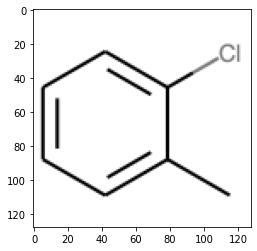

2-Chlorotoluene
-3.52


In [6]:
t = 0

plt.imshow(gimg_array[t], cmap = "gray")
plt.show()

print(name[t])
print(comp_sol[t])

## Generate training_data and test_data:

In [7]:
X_full = gimg_array.reshape(-1, size[0], size[1],1)
y_full = comp_sol

s = 0.8  #size in percent of training data from full data

train_size =round(len(X_full)*s)



X_train = X_full[:train_size]
y_train = y_full[:train_size]

X_test0 = X_full[train_size:]
y_test0 = y_full[train_size:]

X_test, X_val = X_test0[:len(X_test0)//2], X_test0[len(X_test0)//2:]
y_test, y_val = y_test0[:len(y_test0)//2], y_test0[len(y_test0)//2:]




print("X_train:",len(X_train),X_train.shape)
print("y_train:",len(y_train))
print("X_test:",len(X_test),X_test.shape)
print("y_test:",len(y_test))
print("X_val:",len(X_test),X_test.shape)
print("y_val:",len(y_test))


X_train: 902 (902, 128, 128, 1)
y_train: 902
X_test: 113 (113, 128, 128, 1)
y_test: 113
X_val: 113 (113, 128, 128, 1)
y_val: 113


## Augmentation of Dataset to compromise small size

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 126, 126, 16)      160       
_________________________________________________________________
dropout_6 (Dropout)          (None, 126, 126, 16)      0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 61, 61, 4)         580       
_________________________________________________________________
dropout_7 (Dropout)          (None, 61, 61, 4)         0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 30, 30, 4)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 3600)             

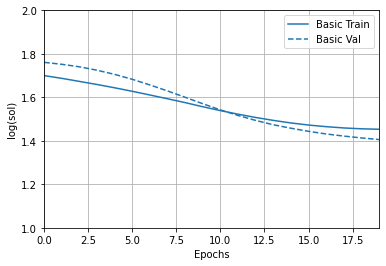

4/4 - 0s
Testing set Mean Abs Error: +/-  1.44 mol/l


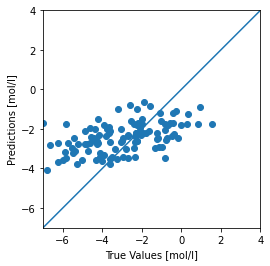

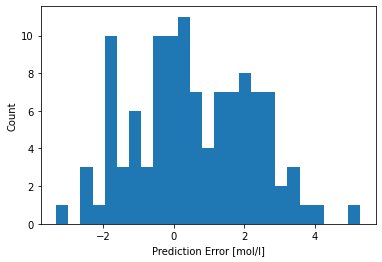

In [19]:
batch_size = 16
epochs = 20
lr = 0.0001

def build_model():
  model = keras.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(X_train.shape[1:])),
    layers.MaxPooling2D((2, 2)),
      
    layers.Conv2D(4, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
      
    layers.Flatten(),
    layers.Dense(1)
  ])


  optimizer = tf.keras.optimizers.Adam(lr)


  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


model = build_model()

print(model.summary())


# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=15,
)


# this is the augmentation configuration we will use for testing:
# nothing
test_datagen = ImageDataGenerator()

#indefinitely generates
# batches of augmented image data
train_generator = train_datagen.flow(X_train, y_train, batch_size = batch_size)

# this is a similar generator, for validation data
validation_generator = test_datagen.flow(X_val, y_val, batch_size = batch_size)


history = model.fit(
        train_generator,
        steps_per_epoch= len(X_train) // batch_size,
        epochs = epochs,
        validation_data = validation_generator,
        validation_steps = len(X_val) // batch_size,
        verbose = 0, callbacks=[tfdocs.modeling.EpochDots()])

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([1, 2])
plt.ylabel('log(sol)')
plt.show()

loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)

print("Testing set Mean Abs Error: +/- {:5.2f} mol/l".format(mae))

test_predictions = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [mol/l]')
plt.ylabel('Predictions [mol/l]')
lims = [-7, 4]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()

error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [mol/l]")
_ = plt.ylabel("Count")

plt.show()